In [34]:
%load_ext autoreload
%autoreload 2
%reload_ext lab_black
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.applications import *
from helpers import *

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.compat.v2.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.python.client import device_lib

In [24]:
np.random.seed(8)
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8233605458871974884
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3156787200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5667836576534971957
physical_device_desc: "device: 0, name: GeForce GTX 980M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


# Loading images

In [25]:
image_dir_train = "data/training/images/"
files = os.listdir(image_dir_train)
n_train = len(files)
print(f"Loading training images, images loaded: {n_train} ")
imgs_train = np.asarray(
    [load_image(image_dir_train + files[i]) for i in range(n_train)]
)
gt_dir_train = "data/training/groundtruth/"
print(f"Loading groundtruth images, images loaded: {n_train} ")
gt_imgs_train = np.asarray(
    [load_image(gt_dir_train + files[i]) for i in range(n_train)]
)

Loading training images, images loaded: 80 
Loading groundtruth images, images loaded: 80 


In [26]:
imgs_train.shape

(80, 400, 400, 3)

In [27]:
gt_imgs_train.shape

(80, 400, 400)

In [7]:
image_size = 400
# Patches for training
img_patches_train = [
    crop_image(imgs_train[i], image_size, image_size) for i in range(n_train)
]
gt_patches_train = [
    crop_image(gt_imgs_train[i], image_size, image_size) for i in range(n_train)
]

# Separate features and labels
X_train = np.asarray(
    [
        img_patches_train[i][j]
        for i in range(len(img_patches_train))
        for j in range(len(img_patches_train[i]))
    ]
)
Y_train = np.asarray(
    [
        gt_patches_train[i][j]
        for i in range(len(gt_patches_train))
        for j in range(len(gt_patches_train[i]))
    ]
)

In [8]:
X_train.shape

(80, 400, 400, 3)

In [9]:
Y_train.shape

(80, 400, 400)

In [10]:
image_dir_val = "data/validating/images/"
files = os.listdir(image_dir_val)
n_val = len(files)
print(f"Loading validating images, images loaded: {n_val} ")
imgs_val = np.asarray([load_image(image_dir_val + files[i]) for i in range(n_val)])
gt_dir_val = "data/validating/groundtruth/"
print(f"Loading validating groundtruth, images loaded: {n_val} ")
gt_imgs_val = np.asarray([load_image(gt_dir_val + files[i]) for i in range(n_val)])

Loading validating images, images loaded: 20 
Loading validating groundtruth, images loaded: 20 


In [11]:
imgs_val.shape

(20, 400, 400, 3)

In [12]:
gt_imgs_val.shape

(20, 400, 400)

In [13]:
image_size = 400
# Patches for validating
img_patches_val = [
    crop_image(imgs_val[i], image_size, image_size) for i in range(n_val)
]
gt_patches_val = [
    crop_image(gt_imgs_val[i], image_size, image_size) for i in range(n_val)
]

# Separate features and labels
X_val = np.asarray(
    [
        img_patches_val[i][j]
        for i in range(len(img_patches_val))
        for j in range(len(img_patches_val[i]))
    ]
)
Y_val = np.asarray(
    [
        gt_patches_val[i][j]
        for i in range(len(gt_patches_val))
        for j in range(len(gt_patches_val[i]))
    ]
)

In [14]:
X_val.shape

(20, 400, 400, 3)

In [15]:
Y_val.shape

(20, 400, 400)

In [16]:
X_train, Y_train = imag_rotation_aug(imgs_train, gt_imgs_train)

In [17]:
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [18]:
print(X_train.shape)
print(Y_train.shape)
n_train = Y_train.shape[0]

(720, 456, 456, 3)
(720, 456, 456)


In [19]:
X_val, Y_val = imag_rotation_aug(imgs_val, gt_imgs_val)

In [20]:
X_val = np.asarray(X_val)
Y_val = np.asarray(Y_val)

In [21]:
print(X_val.shape)
print(Y_val.shape)
n_val = Y_val.shape[0]

(180, 456, 456, 3)
(180, 456, 456)


# Create functions to calcualte precision, recall and F-1 in the training of model

In [28]:
def precision(y_true, y_pred):
    """Compute the Precision for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
        Precision (numpy.float64): the Precision of the batch 
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Compute the Recall for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
       Recall (numpy.float64): the Recal of the batch 
    """

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    """Compute the F-1 for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
       F-1 (numpy.float64): the F-1 of the batch 
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

# ResNet-UNet Architecture

In [41]:
class resnet_unet_model:
    """"""

    def conv_act(self, inputs, out_filters, activation="relu"):
        return Conv2D(
            filters=out_filters,
            activation=activation,
            kernel_size=3,
            strides=1,
            padding="same",
        )(inputs)

    def decoder(
        self,
        inputs,
        mid_filters=512,
        out_filters=256,
        activation="relu",
        block_name="decoder",
    ):
        with K.name_scope(block_name):
            if activation == "leaky_relu":
                activation = None
                conv = LeakyReLU(alpha=0.3)(
                    self.conv_act(inputs, mid_filters, activation)
                )
            else:
                conv = self.conv_act(inputs, mid_filters, activation)
            conv_tr = Conv2DTranspose(
                filters=out_filters,
                activation=activation,
                kernel_size=4,
                strides=2,
                padding="same",
            )(conv)
        return conv_tr

    def __init__(
        self, shape, batch_normalization, activation, dropout, amsgrad=False, lr=1e-4
    ):
        self.shape = shape
        self.batch_normalization = batch_normalization
        self.activation = activation
        self.dropout = dropout
        self.amsgrad = amsgrad
        self.lr = lr
        self.model = self.create_resnet_unet_model()

    def create_resnet_unet_model(self):
        # Set max pooling parameters
        max_pooling_size = 2
        max_pooling_strd = 2

        # load a pretrained ResNet
        num_classes = 2
        resnet50 = ResNet50(
            include_top=False,
            weights="imagenet",
            classes=num_classes,
            input_shape=self.shape,
        )

        resnet50.compile(
            optimizer=Adam(lr=self.lr, amsgrad=self.amsgrad), loss="binary_crossentropy"
        )

        # ResNet convolution outputs
        conv5_out = resnet50.get_layer("conv5_block3_out").output
        conv4_out = resnet50.get_layer("conv4_block6_out").output
        conv3_out = resnet50.get_layer("conv3_block4_out").output
        conv2_out = resnet50.get_layer("conv2_block3_out").output

        # Max pool center layer
        pool = MaxPooling2D(max_pooling_size, strides=max_pooling_strd, padding="same")(
            resnet50.get_output_at(0)
        )

        # Decoder center layer
        dec_center = self.decoder(
            pool,
            mid_filters=self.shape[0] * 2,
            out_filters=self.shape[0],
            activation=self.activation,
            block_name="decoder_center",
        )
        if self.batch_normalization:
            dec_center = BatchNormalization()(dec_center)
        if self.dropout > 0:
            dec_center = Dropout(dropout)(dec_center)

        # Decoder 5th layer
        cat1 = Concatenate()([dec_center, conv5_out])
        dec5 = self.decoder(
            cat1,
            mid_filters=int(self.shape[0] * 2),
            out_filters=int(self.shape[0]),
            activation=self.activation,
            block_name="decoder5",
        )
        if self.batch_normalization:
            dec5 = BatchNormalization()(dec5)
        if self.dropout > 0:
            dec5 = Dropout(self.dropout)(dec5)

        # Decoder 4th layer
        cat2 = Concatenate()([dec5, conv4_out])
        dec4 = self.decoder(
            cat2,
            mid_filters=int(self.shape[0] * 2),
            out_filters=int(self.shape[0]),
            activation=self.activation,
            block_name="decoder4",
        )
        if self.batch_normalization:
            dec4 = BatchNormalization()(dec4)
        if self.dropout > 0:
            dec4 = Dropout(self.dropout)(dec4)

        # Decoder 3rd layer
        cat3 = Concatenate()([dec4, conv3_out])
        dec3 = self.decoder(
            cat3,
            mid_filters=int(self.shape[0]),
            out_filters=int(self.shape[0] // 4),
            activation=self.activation,
            block_name="decoder3",
        )
        if self.batch_normalization:
            dec3 = BatchNormalization()(dec3)
        if self.dropout > 0:
            dec3 = Dropout(self.dropout)(dec3)

        # Decoder 2nd layer
        cat2 = Concatenate()([dec3, conv2_out])
        dec2 = self.decoder(
            cat2,
            mid_filters=int(self.shape[0] // 2),
            out_filters=int(self.shape[0] // 2),
            activation=self.activation,
            block_name="decoder2",
        )
        if self.batch_normalization:
            dec2 = BatchNormalization()(dec2)
        if dropout > 0:
            dec2 = Dropout(self.dropout)(dec2)

        # Decoder 1st layer
        dec1 = self.decoder(
            dec2,
            mid_filters=int(self.shape[0] // 2),
            out_filters=int(self.shape[0] // 8),
            activation=self.activation,
            block_name="decoder1",
        )
        if self.batch_normalization:
            dec1 = BatchNormalization()(dec1)
        if self.dropout > 0:
            dec1 = Dropout(self.dropout)(dec1)

        # Decoder 0th layer
        dec0 = self.conv_act(dec1, out_filters=int(self.shape[0] // 8))
        conv_f = Conv2D(1, 1, activation="sigmoid", padding="same")(dec0)
        flatten_0 = Flatten()(conv_f)
        dense_0 = Dense(
            self.shape[0] / 2,
            kernel_regularizer=l2(1e-6),
            activity_regularizer=l2(1e-6),
        )(flatten_0)
        dropout_0 = Dropout(0.5)(dense_0)
        lk_relu_0 = LeakyReLU(alpha=0.1)(dropout_0)
        dense_1 = Dense(2, kernel_regularizer=l2(1e-6), activity_regularizer=l2(1e-6))(
            lk_relu_0
        )
        dropout_1 = Dropout(0.2)(dense_1)
        output = Activation("sigmoid")(dropout_1)
        model = Model(inputs=resnet50.get_input_at(0), outputs=output)

        # Compile the model using the Adam optimizer with accuracy, recall and f1 metrics
        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(lr=lr, amsgrad=self.amsgrad),
            metrics=["accuracy", recall, f1],
        )

        # Print summary
        model.summary()

        return model

    def train(
        self,
        epochs,
        steps_per_epoch,
        n_train=85,
        n_val=15,
        batch_size=100,
        data_aug_factor=1,
    ):

        # Stop if the model does not get better after 20 steps
        e_stop = EarlyStopping(
            monitor="val_loss", min_delta=0, patience=20, verbose=1, mode="auto"
        )

        # Reduce the learning rate of the model after 30 steps
        reduce_lr = ReduceLROnPlateau(
            monitor="loss", factor=0.5, patience=30, verbose=1, mode="auto"
        )

        # Save the best model
        weights_filename = "model_"
        if self.batch_normalization:
            weights_filename = weights_filename + "batch_"
        weights_filename = (
            weights_filename
            + self.activation
            + "_"
            + str(epochs)
            + "_"
            + "dropout_"
            + str(self.dropout)
            + "_"
            + "{epoch:03d}_"
            + "{f1:03f}_"
            + "{val_accuracy:03f}.h5"
        )
        save_best_model = ModelCheckpoint(
            weights_filename,
            save_best_only=True,
            monitor="val_loss",
            mode="auto",
            verbose=1,
        )

        cbs = [save_best_model, reduce_lr]

        # Train the model
        history = self.model.fit_generator(
            create_minibatch(
                X_train, Y_train, data_aug_factor * n_train, batch_size=batch_size
            ),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            use_multiprocessing=False,
            workers=1,
            callbacks=cbs,
            verbose=1,
            validation_data=create_minibatch(
                X_val, Y_val, data_aug_factor * n_val, batch_size=batch_size
            ),
            validation_steps=steps_per_epoch,
        )

        return history

    def classify(self, X):
        """Classify Image as either road or not.
        Args:
            X (image): part of the image to classify
        Returns:
            Predictions : Predictions for each patch
        """
        # Subdivide the images into blocks with a stride and patch_size of 16
        img_patches = create_patches(X, 16, 16, padding=24)

        # Predict
        predictions = self.model.predict(img_patches)
        predictions = (predictions[:, 0] < predictions[:, 1]) * 1

        # Regroup patches into images
        return predictions.reshape(X.shape[0], -1)

    def load(self, filename):
        """Loads Saved Model.
        Args:
           filename (string): name of the model
           
        """
        # Load the model (used for submission)
        dependencies = {"recall": recall, "f1": f1}
        self.model = load_model(filename, custom_objects=dependencies)

    def save(self, filename):
        """Saves trained model.
        Args:
           filename (string): name of the model
           
        """
        self.model.save(filename)

In [42]:
data_aug_factor = 1
batch_normalization = True
activation = "relu"
dropout = 0
amsgrad = False
lr = 1e-4

In [43]:
# Training parameters
EPOCHS = 80
STEPS_PER_EPOCH = 100
batch_size = 100

model = resnet_unet_model(
    shape=(64, 64, 3),
    batch_normalization=batch_normalization,
    activation=activation,
    dropout=dropout,
    amsgrad=amsgrad,
    lr=lr,
)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

# Train the Model


In [44]:
# Train the model
history = model.train(
    EPOCHS, STEPS_PER_EPOCH, n_train, n_val, batch_size, data_aug_factor
)

Epoch 1/80
 99/100 [============================>.] - ETA: 0s - loss: 0.5650 - accuracy: 0.7157 - recall: 0.6178 - f1: 0.6844
Epoch 00001: val_loss improved from inf to 0.57014, saving model to model_batch_relu_80_dropout_0_001_0.684290_0.746400.h5
100/100 [==============================] - 75s 752ms/step - loss: 0.5646 - accuracy: 0.7156 - recall: 0.6177 - f1: 0.6843 - val_loss: 0.5701 - val_accuracy: 0.7464 - val_recall: 0.7464 - val_f1: 0.7464
Epoch 2/80
 99/100 [============================>.] - ETA: 0s - loss: 0.3854 - accuracy: 0.7895 - recall: 0.6910 - f1: 0.7660
Epoch 00002: val_loss did not improve from 0.57014
100/100 [==============================] - 71s 712ms/step - loss: 0.3840 - accuracy: 0.7904 - recall: 0.6917 - f1: 0.7669 - val_loss: 1.0381 - val_accuracy: 0.2591 - val_recall: 0.2591 - val_f1: 0.2591
Epoch 3/80
 99/100 [============================>.] - ETA: 0s - loss: 0.3085 - accuracy: 0.8383 - recall: 0.7390 - f1: 0.8199
Epoch 00003: val_loss did not improve from 0

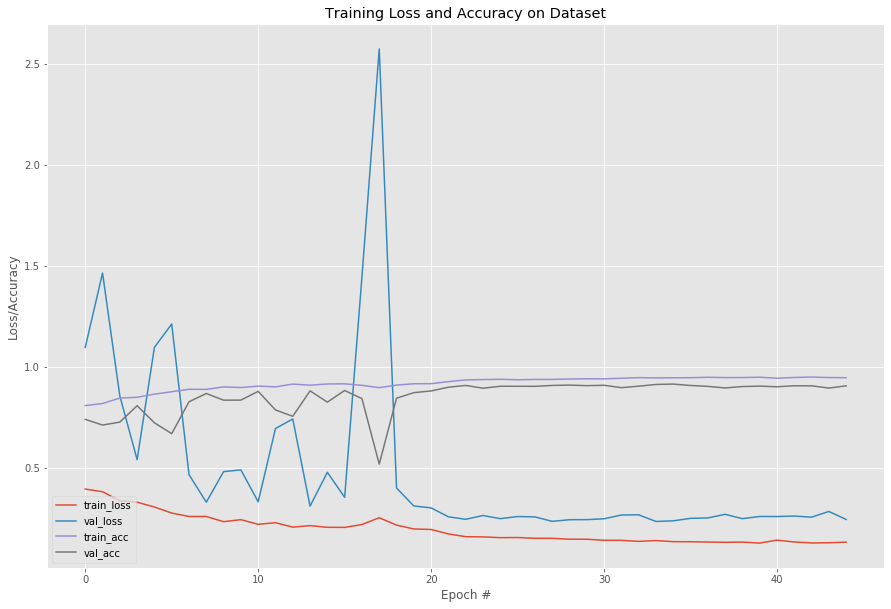

In [26]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"][1:], label="train_loss")
plt.plot(history.history["val_loss"][1:], label="val_loss")
plt.plot(history.history["accuracy"][1:], label="train_acc")
plt.plot(history.history["val_accuracy"][1:], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Unet_batchnorm.png")
plt.show()

In [47]:
# Instantiate the model
lr = 1e-4
model = resnet_unet_model(
    shape=(64, 64, 3),
    batch_normalization=batch_normalization,
    activation=activation,
    dropout=dropout,
    amsgrad=amsgrad,
    lr=lr,
)

# Load the model
model.load("best_model.h5")

model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "resnet_unet.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________